Imports

In [11]:
import os
from scipy.io import loadmat
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

Data Loading and Making Windows

In [12]:
with ZipFile('USC-HAD.zip','r') as zipobj:
    zipobj.extractall()

In [ ]:
def make_windows(X,y_data,window_size,X_new,y_new):
    X = X[::10]
    len_X = len(X)
    for i in range(0,len_X):
        if i+window_size > len_X:
            break
        X_new.append(X[i:i+window_size])
        y_new.append(y_data)

    return X_new,y_new

In [ ]:
X_raw = []
y = []

root = "/content/USC-HAD"
for subdir in os.listdir(root):
    if subdir.startswith("Sub"):
        sub_path = os.path.join(root,subdir)
        for filename in os.listdir(sub_path):
            curr_path = os.path.join(sub_path,filename)
            data = loadmat(curr_path)
            X_data = data['sensor_readings']
            y_data = 0
            if len(filename) == 9:
                y_data = int(filename[1:3])-1
            else:
                y_data = int(filename[1])-1

            X_raw,y = make_windows(X_data,y_data,300,X_raw,y)


X_raw = np.array(X_raw)
y = np.array(y)

print(X_raw.shape)
print(y.shape)

(74834, 300, 6)
(74834,)


Split Data

In [14]:
from sklearn.model_selection import train_test_split

X_train,X_tmp,y_train,y_tmp = train_test_split(X_raw,y,train_size=0.70,random_state=42)
X_val,X_test,y_val,y_test = train_test_split(X_tmp,y_tmp,train_size=0.50,random_state=42)

Model Building

In [15]:
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(300, 6)),
    Dense(256, activation='relu'),
    Dense(12, activation='softmax')
])

In [16]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True,min_delta=0.01)

In [18]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data = (X_val,y_val), callbacks=[early_stopping])

Epoch 1/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.8503 - loss: 0.4521 - val_accuracy: 0.9807 - val_loss: 0.0610
Epoch 2/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.9813 - loss: 0.0612 - val_accuracy: 0.9876 - val_loss: 0.0361
Epoch 3/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.9702 - loss: 0.0954 - val_accuracy: 0.9792 - val_loss: 0.0916
Epoch 4/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 43s 20ms/step - accuracy: 0.9899 - loss: 0.0385 - val_accuracy: 0.9968 - val_loss: 0.0097
Epoch 5/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.9922 - loss: 0.0252 - val_accuracy: 0.9968 - val_loss: 0.0105
Epoch 6/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 38s 18ms/step - accuracy: 0.9977 - loss: 0.0081 - val_accuracy: 0.9979 - val_loss: 0.0064
Epoch 7/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 44s 19ms/step - accuracy: 0.9965 - loss: 0.0125 - val_accuracy: 0.9991 - val_loss: 0.0031
Epoch 8/10
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - accuracy: 0.9990 -

Plotting Accuracy and Loss

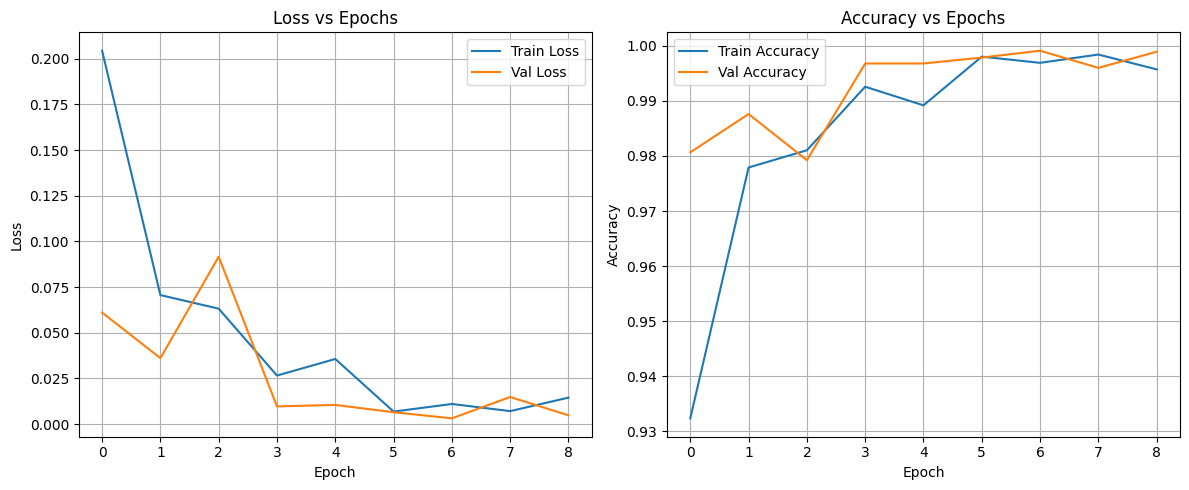

In [19]:
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Making Predictions on Validation and Test Data

In [20]:
y_pred_test_classes = model.predict(X_test)

351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


In [21]:
y_pred_test = np.argmax(y_pred_test_classes, axis=1)
accuracy_test = sum(y_pred_test == y_test) / len(y_test)
print(f"Test Accuracy: {accuracy_test * 100:.2f}%")

Test Accuracy: 99.61%


In [22]:
y_pred_val_classes= model.predict(X_val)
accuracy_val = sum(np.argmax(y_pred_val_classes, axis=1) == y_val) / len(y_val)
print(f"Validation Accuracy: {accuracy_val * 100:.2f}%")

351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Validation Accuracy: 99.68%


Saving the Final Model

In [23]:
model.save('lstm_model_no_scale.keras')